In [1]:
# %% [code]
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

In [2]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#! pip install lightgbm

In [3]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [4]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [5]:
num_rows=None
try:
    from google.colab import drive
    drive.mount('/content/drive')
    df=pd.read_csv("/content/drive/MyDrive/Notebooks/P7/application_train.csv")
        
except ModuleNotFoundError :
    df = pd.read_csv(r'C:\Users\Hugues\gdrive\Notebooks\P7\application_train.csv', nrows= num_rows)

## Preprocess application_train.csv and application_test.csv

In [6]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        df=pd.read_csv("/content/drive/MyDrive/Notebooks/P7/application_train.csv")
        
    except ModuleNotFoundError :
      
        df = pd.read_csv(r'C:\Users\Hugues\gdrive\Notebooks\P7\application_train.csv', nrows= num_rows)
  
    
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        test_df = pd.read_csv("/content/drive/MyDrive/Notebooks/P7/application_test.csv")
        
    except ModuleNotFoundError :
     
        test_df = pd.read_csv(r'C:\Users\Hugues\gdrive\Notebooks\P7\application_test.csv', nrows= num_rows)    

    
    df.info()
    df.shape
    df.transpose()
    
    test_df.info()
    test_df.shape
    test_df.transpose()
    
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [7]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    #bureau = pd.read_csv('../input/bureau.csv', nrows = num_rows)
    
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        bureau =pd.read_csv("/content/drive/MyDrive/Notebooks/P7/bureau.csv")
        
    except ModuleNotFoundError :
     
        bureau = pd.read_csv(r'C:\Users\Hugues\gdrive\Notebooks\P7\bureau.csv', nrows= num_rows)
    
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        bb = pd.read_csv("/content/drive/MyDrive/Notebooks/P7/bureau_balance.csv")
        
    except ModuleNotFoundError :
    
        bb = pd.read_csv(r'C:\Users\Hugues\gdrive\Notebooks\P7\bureau_balance.csv', nrows= num_rows)
    
  
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [8]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        prev =pd.read_csv("/content/drive/MyDrive/Notebooks/P7/previous_application.csv")
        
    except ModuleNotFoundError :
     
        prev = pd.read_csv(r'C:\Users\Hugues\gdrive\Notebooks\P7\previous_application.csv', nrows= num_rows)
    
    
    
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [9]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    #pos = pd.read_csv('../input/POS_CASH_balance.csv', nrows = num_rows)
    
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        pos =pd.read_csv("/content/drive/MyDrive/Notebooks/P7/POS_CASH_balance.csv")
        
    except ModuleNotFoundError :
  
        pos= pd.read_csv(r'C:\Users\Hugues\gdrive\Notebooks\P7\POS_CASH_balance.csv', nrows= num_rows)
    
        
    
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    

In [10]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    #ins = pd.read_csv('../input/installments_payments.csv', nrows = num_rows)
    
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        ins =pd.read_csv("/content/drive/MyDrive/Notebooks/P7/installments_payments.csv")
        
    except ModuleNotFoundError :

        ins= pd.read_csv(r'C:\Users\Hugues\gdrive\Notebooks\P7\installments_payments.csv', nrows= num_rows)
    
    
    
    
    
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [11]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    #cc = pd.read_csv('../input/credit_card_balance.csv', nrows = num_rows)
    
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        cc =pd.read_csv("/content/drive/MyDrive/Notebooks/P7/credit_card_balance.csv")
        
    except ModuleNotFoundError :
        #img =Image.open(r'C:\Users\Hugues\gdrive\Notebooks\P8\logobio.png')
        cc = pd.read_csv(r'C:\Users\Hugues\gdrive\Notebooks\P7\credit_card_balance.csv', nrows= num_rows)
    
    
           
    
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [12]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            importance_type= 'gain',
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [13]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 40s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 63s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 56s
Installments payments df shape: (339587, 26)
Process installments payments - done in 127s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 80s
check json column - done in 4s
Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)


C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797104	training's binary_logloss: 0.234829	valid_1's auc: 0.776089	valid_1's binary_logloss: 0.246759
[400]	training's auc: 0.819226	training's binary_logloss: 0.22537	valid_1's auc: 0.787159	valid_1's binary_logloss: 0.242511
[600]	training's auc: 0.834155	training's binary_logloss: 0.219277	valid_1's auc: 0.790742	valid_1's binary_logloss: 0.241208
[800]	training's auc: 0.846219	training's binary_logloss: 0.214311	valid_1's auc: 0.792638	valid_1's binary_logloss: 0.240572
[1000]	training's auc: 0.856646	training's binary_logloss: 0.20991	valid_1's auc: 0.793314	valid_1's binary_logloss: 0.240345
[1200]	training's auc: 0.866329	training's binary_logloss: 0.205763	valid_1's auc: 0.794016	valid_1's binary_logloss: 0.240111
[1400]	training's auc: 0.875268	training's binary_logloss: 0.2017	valid_1's auc: 0.794374	valid_1's binary_logloss: 0.240002
[1600]

C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.796504	training's binary_logloss: 0.235573	valid_1's auc: 0.777058	valid_1's binary_logloss: 0.241702
[400]	training's auc: 0.819063	training's binary_logloss: 0.226043	valid_1's auc: 0.786754	valid_1's binary_logloss: 0.237454
[600]	training's auc: 0.833962	training's binary_logloss: 0.21997	valid_1's auc: 0.788941	valid_1's binary_logloss: 0.236447
[800]	training's auc: 0.846139	training's binary_logloss: 0.214955	valid_1's auc: 0.790289	valid_1's binary_logloss: 0.235906
[1000]	training's auc: 0.856195	training's binary_logloss: 0.210675	valid_1's auc: 0.790743	valid_1's binary_logloss: 0.235667
[1200]	training's auc: 0.865472	training's binary_logloss: 0.206638	valid_1's auc: 0.79094	valid_1's binary_logloss: 0.23555
[1400]	training's auc: 0.874355	training's binary_logloss: 0.202693	valid_1's auc: 0.791202	valid_1's binary_logloss: 0.235424
[1600

C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797097	training's binary_logloss: 0.235026	valid_1's auc: 0.76787	valid_1's binary_logloss: 0.246536
[400]	training's auc: 0.819952	training's binary_logloss: 0.225433	valid_1's auc: 0.778311	valid_1's binary_logloss: 0.242546
[600]	training's auc: 0.834998	training's binary_logloss: 0.219239	valid_1's auc: 0.781675	valid_1's binary_logloss: 0.241422
[800]	training's auc: 0.8474	training's binary_logloss: 0.214093	valid_1's auc: 0.783594	valid_1's binary_logloss: 0.240809
[1000]	training's auc: 0.857595	training's binary_logloss: 0.209775	valid_1's auc: 0.784536	valid_1's binary_logloss: 0.240494
[1200]	training's auc: 0.866985	training's binary_logloss: 0.205683	valid_1's auc: 0.785113	valid_1's binary_logloss: 0.240377
[1400]	training's auc: 0.875537	training's binary_logloss: 0.201832	valid_1's auc: 0.785241	valid_1's binary_logloss: 0.240407
Fold 

C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.796781	training's binary_logloss: 0.23554	valid_1's auc: 0.778094	valid_1's binary_logloss: 0.241263
[400]	training's auc: 0.81928	training's binary_logloss: 0.225978	valid_1's auc: 0.788498	valid_1's binary_logloss: 0.236955
[600]	training's auc: 0.834386	training's binary_logloss: 0.219837	valid_1's auc: 0.792236	valid_1's binary_logloss: 0.235482
[800]	training's auc: 0.846366	training's binary_logloss: 0.214924	valid_1's auc: 0.793725	valid_1's binary_logloss: 0.23491
[1000]	training's auc: 0.857037	training's binary_logloss: 0.210442	valid_1's auc: 0.794901	valid_1's binary_logloss: 0.234455
[1200]	training's auc: 0.8665	training's binary_logloss: 0.206311	valid_1's auc: 0.795161	valid_1's binary_logloss: 0.234325
[1400]	training's auc: 0.875286	training's binary_logloss: 0.202334	valid_1's auc: 0.795642	valid_1's binary_logloss: 0.234145
[1600]	

C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.796443	training's binary_logloss: 0.236317	valid_1's auc: 0.78032	valid_1's binary_logloss: 0.234124
[400]	training's auc: 0.819068	training's binary_logloss: 0.226741	valid_1's auc: 0.790482	valid_1's binary_logloss: 0.229854
[600]	training's auc: 0.833992	training's binary_logloss: 0.220619	valid_1's auc: 0.793639	valid_1's binary_logloss: 0.228569
[800]	training's auc: 0.846192	training's binary_logloss: 0.215603	valid_1's auc: 0.795317	valid_1's binary_logloss: 0.227936
[1000]	training's auc: 0.856531	training's binary_logloss: 0.211213	valid_1's auc: 0.796348	valid_1's binary_logloss: 0.22756
[1200]	training's auc: 0.866038	training's binary_logloss: 0.207091	valid_1's auc: 0.797078	valid_1's binary_logloss: 0.227334
[1400]	training's auc: 0.874456	training's binary_logloss: 0.203282	valid_1's auc: 0.797234	valid_1's binary_logloss: 0.227263
[160

C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797404	training's binary_logloss: 0.235337	valid_1's auc: 0.76717	valid_1's binary_logloss: 0.243343
[400]	training's auc: 0.820012	training's binary_logloss: 0.225758	valid_1's auc: 0.778167	valid_1's binary_logloss: 0.239452
[600]	training's auc: 0.835049	training's binary_logloss: 0.219617	valid_1's auc: 0.782224	valid_1's binary_logloss: 0.238116
[800]	training's auc: 0.847157	training's binary_logloss: 0.214639	valid_1's auc: 0.783885	valid_1's binary_logloss: 0.237496
[1000]	training's auc: 0.857708	training's binary_logloss: 0.210211	valid_1's auc: 0.784889	valid_1's binary_logloss: 0.237139
[1200]	training's auc: 0.867254	training's binary_logloss: 0.205959	valid_1's auc: 0.785179	valid_1's binary_logloss: 0.236995
[1400]	training's auc: 0.876057	training's binary_logloss: 0.201915	valid_1's auc: 0.785234	valid_1's binary_logloss: 0.236983
Fol

C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797268	training's binary_logloss: 0.235527	valid_1's auc: 0.774539	valid_1's binary_logloss: 0.240657
[400]	training's auc: 0.819627	training's binary_logloss: 0.225979	valid_1's auc: 0.784495	valid_1's binary_logloss: 0.236476
[600]	training's auc: 0.83472	training's binary_logloss: 0.219851	valid_1's auc: 0.787703	valid_1's binary_logloss: 0.235247
[800]	training's auc: 0.847018	training's binary_logloss: 0.21483	valid_1's auc: 0.78932	valid_1's binary_logloss: 0.234726
[1000]	training's auc: 0.85732	training's binary_logloss: 0.210487	valid_1's auc: 0.78994	valid_1's binary_logloss: 0.234503
[1200]	training's auc: 0.866926	training's binary_logloss: 0.206324	valid_1's auc: 0.790406	valid_1's binary_logloss: 0.234408
[1400]	training's auc: 0.875563	training's binary_logloss: 0.20244	valid_1's auc: 0.790384	valid_1's binary_logloss: 0.234439
Fold  7 

C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797384	training's binary_logloss: 0.235077	valid_1's auc: 0.770478	valid_1's binary_logloss: 0.245343
[400]	training's auc: 0.819664	training's binary_logloss: 0.225542	valid_1's auc: 0.781776	valid_1's binary_logloss: 0.240982
[600]	training's auc: 0.834599	training's binary_logloss: 0.219451	valid_1's auc: 0.785968	valid_1's binary_logloss: 0.239525
[800]	training's auc: 0.846348	training's binary_logloss: 0.214629	valid_1's auc: 0.787951	valid_1's binary_logloss: 0.238904
[1000]	training's auc: 0.856847	training's binary_logloss: 0.210207	valid_1's auc: 0.788733	valid_1's binary_logloss: 0.238634
[1200]	training's auc: 0.866335	training's binary_logloss: 0.206035	valid_1's auc: 0.789318	valid_1's binary_logloss: 0.238496
[1400]	training's auc: 0.875156	training's binary_logloss: 0.202086	valid_1's auc: 0.789737	valid_1's binary_logloss: 0.238361
[1

C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.796262	training's binary_logloss: 0.235491	valid_1's auc: 0.780614	valid_1's binary_logloss: 0.242519
[400]	training's auc: 0.819304	training's binary_logloss: 0.225829	valid_1's auc: 0.7906	valid_1's binary_logloss: 0.238067
[600]	training's auc: 0.834369	training's binary_logloss: 0.219696	valid_1's auc: 0.794411	valid_1's binary_logloss: 0.236568
[800]	training's auc: 0.846365	training's binary_logloss: 0.214734	valid_1's auc: 0.795589	valid_1's binary_logloss: 0.235997
[1000]	training's auc: 0.857347	training's binary_logloss: 0.21016	valid_1's auc: 0.795693	valid_1's binary_logloss: 0.235837
[1200]	training's auc: 0.866959	training's binary_logloss: 0.20599	valid_1's auc: 0.796198	valid_1's binary_logloss: 0.235632
[1400]	training's auc: 0.876094	training's binary_logloss: 0.201939	valid_1's auc: 0.796356	valid_1's binary_logloss: 0.235572
[1600]

C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hugues\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.796896	training's binary_logloss: 0.235586	valid_1's auc: 0.771623	valid_1's binary_logloss: 0.240838
[400]	training's auc: 0.819574	training's binary_logloss: 0.226061	valid_1's auc: 0.782718	valid_1's binary_logloss: 0.236567
[600]	training's auc: 0.834468	training's binary_logloss: 0.21995	valid_1's auc: 0.786322	valid_1's binary_logloss: 0.235229
[800]	training's auc: 0.846691	training's binary_logloss: 0.214993	valid_1's auc: 0.788052	valid_1's binary_logloss: 0.234624
[1000]	training's auc: 0.857452	training's binary_logloss: 0.210465	valid_1's auc: 0.789127	valid_1's binary_logloss: 0.234272
[1200]	training's auc: 0.867238	training's binary_logloss: 0.206246	valid_1's auc: 0.789493	valid_1's binary_logloss: 0.23412
[1400]	training's auc: 0.876043	training's binary_logloss: 0.202265	valid_1's auc: 0.789718	valid_1's binary_logloss: 0.23401
[1600

C:\Users\Hugues\AppData\Local\Temp\ipykernel_14524\1693211161.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['TARGET'] = sub_preds


Run LightGBM with kfold - done in 22714s
Full model run - done in 23101s


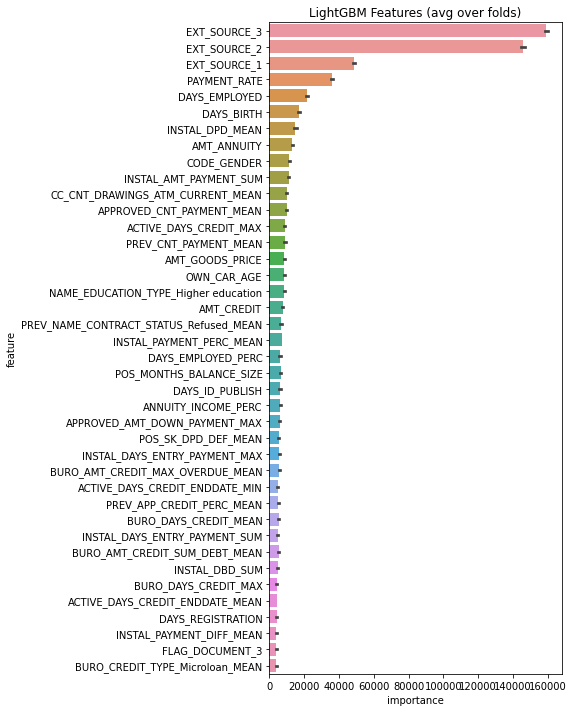

In [14]:
def main(debug = False):
    num_rows = 1000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("check json column") :
        for c in df.columns.tolist() :
            df.rename(columns={c: c.replace("/", "")}, inplace=True)  
            df.rename(columns={c: c.replace(":", "")}, inplace=True)
            df.rename(columns={c: c.replace(",", "")}, inplace=True)
        
    with timer("Run LightGBM with kfold"):
            feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        main()

In [15]:
df.shape

(307511, 122)

In [16]:
df.reset_index().drop(columns='index').to_csv("basep7.csv")